In [1]:
import numpy as np                       #Just good ol' numpy
import matplotlib.pyplot as plt          #Just good ol' pyplot
from os import listdir                   #To read the files in a folder, like ls
import re                                #Regular Expressions library. Contains "split"
import os
from pathlib import Path
import pandas as pd


import time as tmm



In [3]:
file_loc = '/location/of/dataset/wisdm-dataset/'
key_file = file_loc+'activity_key.txt'
dtype = np.dtype([('activity', np.unicode_, 16), ('label', np.unicode_, 16)])
activity,label = np.loadtxt(key_file,dtype=dtype, delimiter='=',usecols=(0,1), unpack=True)
for i in range(0,len(activity)):
    print(label[i],activity[i])

 A walking 
 B jogging 
 C stairs 
 D sitting 
 E standing 
 F typing 
 G teeth 
 H soup 
 I chips 
 J pasta 
 K drinking 
 L sandwich 
 M kicking 
 O catch 
 P dribbling 
 Q writing 
 R clapping 
 S folding 


In [4]:
activity_broad = ['General','Hand oriented',"Eating"]
def activities_broad(activity):
    if activity=='A' or activity=='B' or activity=='C' or activity=='D' or activity=='E' or activity=='M':
        activity_simplified = 'General'
    elif activity=='P' or activity=='O' or activity=='F' or activity=='Q' or activity=='R' or activity=='G' or activity=='S':
        activity_simplified = 'Hand oriented'
    elif activity=='J' or activity=='H' or activity=='L' or activity=='I' or activity=='K':
        activity_simplified = 'Eating'
    else:
        activity_simplified = 'error!'
    return activity_simplified


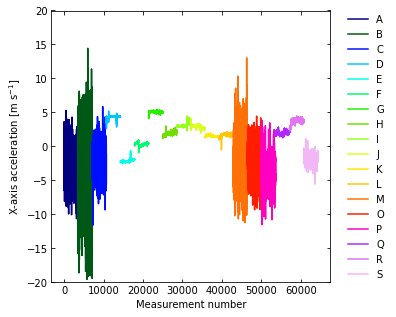

In [26]:
phone_accel_loc = file_loc + 'raw/phone/accel/'
phone_gyro_loc = file_loc + 'raw/phone/gyro/'

files_phone_accel_loc = sorted(os.listdir(phone_accel_loc))
files_phone_gyro_loc = sorted(os.listdir(phone_gyro_loc))

file = open(phone_accel_loc+files_phone_accel_loc[1], "r")
dtype = np.dtype([('subject_id', np.int32),('activity_code', np.unicode_, 16), ('timestamp',np.int64), ('x_acc',np.float64), ('y_acc',np.float64), ('z_acc',np.float64)])
subject_id,activity_code,timestamp,x,y,z = np.loadtxt(phone_accel_loc+files_phone_accel_loc[1],dtype=dtype,delimiter=',',comments=';',usecols=(0,1,2,3,4,5), unpack=True)

df = pd.DataFrame({'subject_id':subject_id,
                   'x': x,
                   'y': y,
                   'z': z,
                   'timestamp':timestamp,
                   'activity_code':activity_code})

groups = df.groupby('activity_code')
colors = iter(plt.cm.gist_ncar(np.linspace(0,1,len(activity)+1)))
fig = plt.figure()
ax = fig.add_subplot(111)
for name, group in groups:
    ax.plot(group.x, c=next(colors),linestyle='-', markersize=8, label=name)
ax.set_xlabel("Measurement number")
ax.set_ylim(-20,20)
ax.tick_params(direction="in", which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
fig.set_size_inches([5,5])
ax.set_ylabel(r"X-axis acceleration [$\mathrm{m} \ \mathrm{s}^{-1}]$")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)

plt.savefig('./example_plot.pdf', bbox_inches='tight')
plt.show()

In [13]:
def data_reducer(device,
                 measurement,
                 nsteps):


    
    phone_accel_loc = file_loc + 'raw/phone/accel/'
    phone_gyro_loc = file_loc + 'raw/phone/gyro/'
    watch_accel_loc = file_loc + 'raw/watch/accel/'
    watch_gyro_loc = file_loc + 'raw/watch/gyro/'

    files_phone_accel_loc = sorted(os.listdir(phone_accel_loc))
    files_phone_gyro_loc = sorted(os.listdir(phone_gyro_loc))
    files_watch_accel_loc = sorted(os.listdir(watch_accel_loc))
    files_watch_gyro_loc = sorted(os.listdir(watch_gyro_loc))
    
    if device=='phone' and measurement=='accel':
        loc = phone_accel_loc
        selected_files = files_phone_accel_loc
    elif device=='phone' and measurement=='gyro':
        loc = phone_gyro_loc
        selected_files = files_phone_gyro_loc
    elif device=='watch' and measurement=='accel':
        loc = watch_accel_loc
        selected_files = files_watch_accel_loc
    elif device=='watch' and measurement=='gyro':
        loc = watch_gyro_loc
        selected_files = files_watch_gyro_loc
    else:
        print('data input choice not recognized, using default (phone, accel)')
        loc = phone_accel_loc
        selected_files = files_phone_accel_loc

    act_reduced = []
    act_broad_reduced = []
    subject_id_reduced = []
    X_reduced = [[],[],[],[],[],[],[],[],[],[]]
    Y_reduced = [[],[],[],[],[],[],[],[],[],[]]
    Z_reduced = [[],[],[],[],[],[],[],[],[],[]]
    XYZ_reduced = [X_reduced,Y_reduced,Z_reduced]
    XYZ_avg_reduced = [[],[],[]]
    XYZ_peak_reduced = [[],[],[]]
    XYZ_stddev_reduced = [[],[],[]]
    XYZ_var_reduced = [[],[],[]]
    norm_reduced = []

    for file in selected_files:
        if file!='.DS_Store':
            dtype = np.dtype([('subject_id', np.int32),('activity_code', np.unicode_, 16), ('timestamp',np.int64), ('x_acc',np.float64), ('y_acc',np.float64), ('z_acc',np.float64)])
            subject_id,activity_code,timestamp,x,y,z = np.loadtxt(loc+file,dtype=dtype,delimiter=',',comments=';',usecols=(0,1,2,3,4,5), unpack=True)
            if subject_id[0]%10==0:
                print(subject_id[0],' out of 50')
            step = [xx for xx in range(0, len(timestamp))]
            vector_length = np.sqrt(np.power(x,2)+np.power(y,2)+np.power(z,2))
            df = pd.DataFrame({'x': x,
                               'y': y,
                               'z': z,
                               'subject_id':subject_id,
                               'timestamp':timestamp,
                               'activity_code':activity_code,
                               'step':step,
                                'vector_length':vector_length})

            for bla1,bla2 in df.groupby(['subject_id','activity_code']):
                bin_top = bla2['step'].max()
                bin_bot = bla2['step'].min()
                bins = [xx for xx in range(bin_bot-1, bin_top-1, nsteps)]
                new_bla = bla2.groupby(pd.cut(bla2['step'], bins))
                for a,b in new_bla:
                    act_reduced.append(bla1[1])
                    act_broad_reduced.append(activities_broad(bla1[1]))
                    subject_id_reduced.append(bla1[0])
                    norm_reduced.append(b['vector_length'].mean())

                    vals = ['x','y','z']
                    for j in range(0,3):
                        bin_top_2 = b[vals[j]].max()
                        bin_bot_2 = b[vals[j]].min()
                        loc_max = b[vals[j]].idxmax()
                        loc_min = b[vals[j]].idxmin()
                        time_min_max = abs(loc_max-loc_min)*50e-3
                        dbin = abs(bin_top_2-bin_bot_2)/10
                        bins = np.arange(bin_bot_2, bin_top_2+dbin, dbin)
                        bins[0]=bins[0]-0.01*dbin
                        bins[-1]=bins[-1]+0.01*dbin

                        bzz = b.groupby(pd.cut(b[vals[j]], bins))
                        sums =0
                        k=0
                        for bzz_a,bzz_b in bzz:
                            sums = sums+len(bzz_b)
                            if k<10:
                                XYZ_reduced[j][k].append(float(len(bzz_b))/float(nsteps))
                            k=k+1
                        if sums!=nsteps:
                            print(bla1,a,vals[j],'total counts',sums)
                        XYZ_avg_reduced[j].append(b[vals[j]].mean())
                        XYZ_peak_reduced[j].append(time_min_max)
                        XYZ_stddev_reduced[j].append(b[vals[j]].std())
                        XYZ_var_reduced[j].append(b[vals[j]].std())


    features = pd.DataFrame({  'X0': XYZ_reduced[0][0],
                               'X1': XYZ_reduced[0][1],
                               'X2': XYZ_reduced[0][2],
                               'X3': XYZ_reduced[0][3],
                               'X4': XYZ_reduced[0][4],
                               'X5': XYZ_reduced[0][5],
                               'X6': XYZ_reduced[0][6],
                               'X7': XYZ_reduced[0][7],
                               'X8': XYZ_reduced[0][8],
                               'X9': XYZ_reduced[0][9],
                               'Y0': XYZ_reduced[1][0],
                               'Y1': XYZ_reduced[1][1],
                               'Y2': XYZ_reduced[1][2],
                               'Y3': XYZ_reduced[1][3],
                               'Y4': XYZ_reduced[1][4],
                               'Y5': XYZ_reduced[1][5],
                               'Y6': XYZ_reduced[1][6],
                               'Y7': XYZ_reduced[1][7],
                               'Y8': XYZ_reduced[1][8],
                               'Y9': XYZ_reduced[1][9],
                               'Z0': XYZ_reduced[2][0],
                               'Z1': XYZ_reduced[2][1],
                               'Z2': XYZ_reduced[2][2],
                               'Z3': XYZ_reduced[2][3],
                               'Z4': XYZ_reduced[2][4],
                               'Z5': XYZ_reduced[2][5],
                               'Z6': XYZ_reduced[2][6],
                               'Z7': XYZ_reduced[2][7],
                               'Z8': XYZ_reduced[2][8],
                               'Z9': XYZ_reduced[2][9],
                               'X_avg':XYZ_avg_reduced[0],
                               'Y_avg':XYZ_avg_reduced[1],
                               'Z_avg':XYZ_avg_reduced[2],
                               'X_peak':XYZ_peak_reduced[0],
                               'Y_peak':XYZ_peak_reduced[1],
                               'Z_peak':XYZ_peak_reduced[2],
                               'X_stdev':XYZ_stddev_reduced[0],
                               'Y_stdev':XYZ_stddev_reduced[1],
                               'Z_stdev':XYZ_stddev_reduced[2],
                               'X_var':XYZ_var_reduced[0],
                               'Y_var':XYZ_var_reduced[1],
                               'Z_var':XYZ_var_reduced[2],
                               'norm':norm_reduced})

    target_A = pd.DataFrame({'activity': act_reduced})
    target_B = pd.DataFrame({'subject_id':subject_id_reduced})
    target_C = pd.DataFrame({'act_broad_reduced':act_broad_reduced})

    
    return features, target_A, target_B, target_C

# features, target_A, target_B, target_C = data_reducer("phone","accel",200)

# print(features)
# print(target_A)
# print(target_B)
# print(target_C)




reading data for  phone accel
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50
kNN model for  phone accel


/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


kNN model accuracy for phone accel using activity data 0.4793733681462141


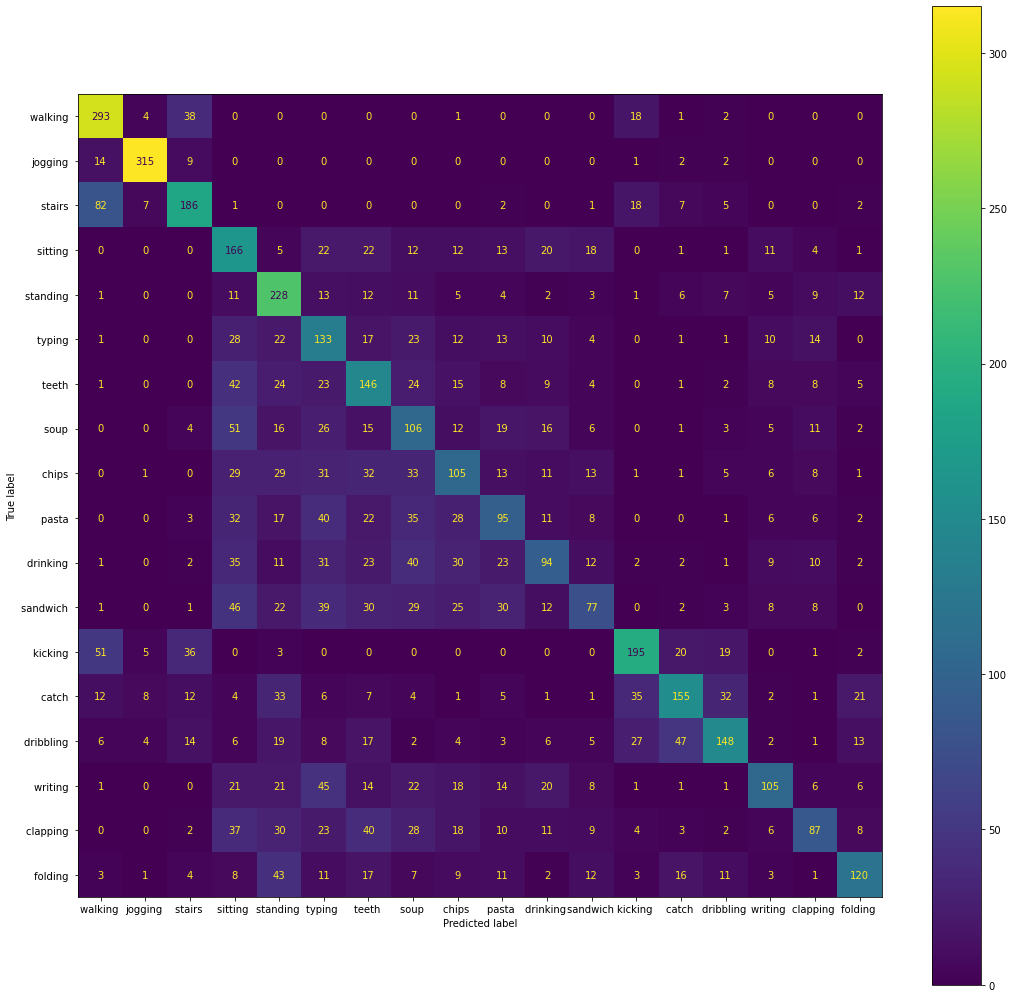

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


kNN model accuracy for phone accel using simplified activity data 0.7211488250652741


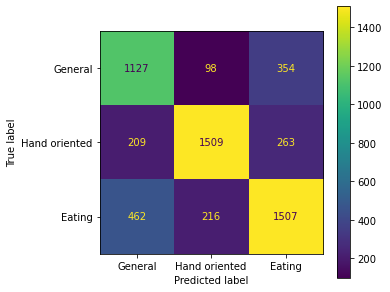

Random forest model for  phone accel


<ipython-input-16-ec1dfd7c2796>:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  67.86771105308964


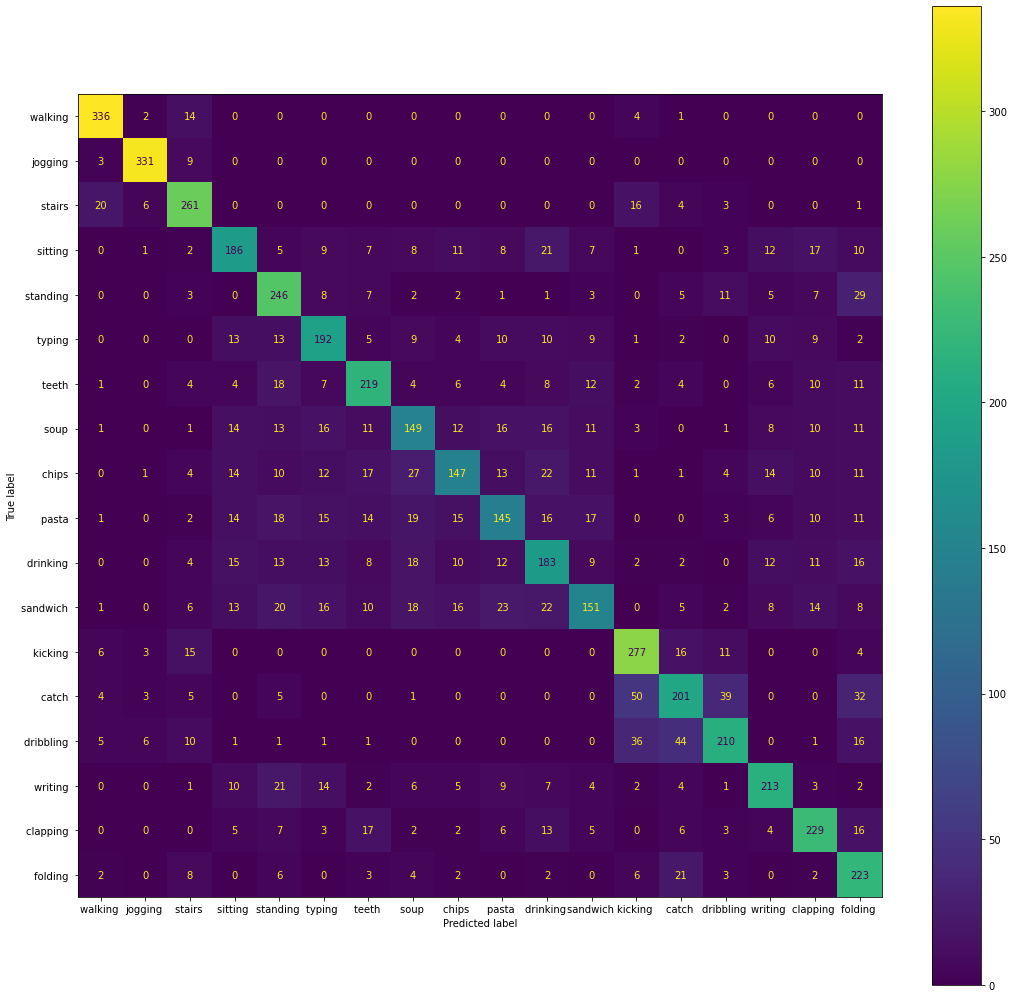

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-16-ec1dfd7c2796>:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.66144473455178


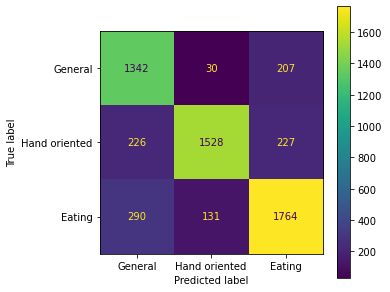

Decision tree model for  phone accel
Training Accuracy :  100.0
Validation Accuracy :  62.90687554395126


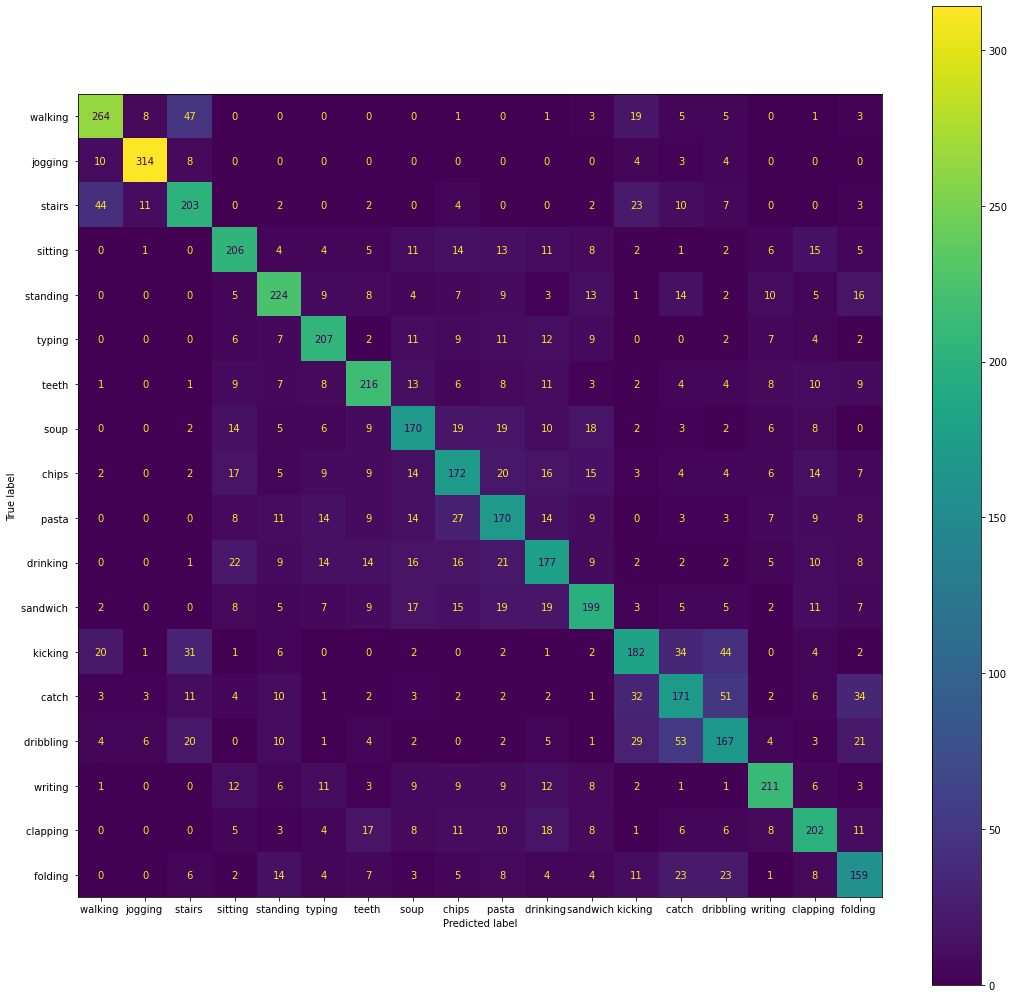

Training Accuracy :  100.0
Validation Accuracy :  82.15839860748477


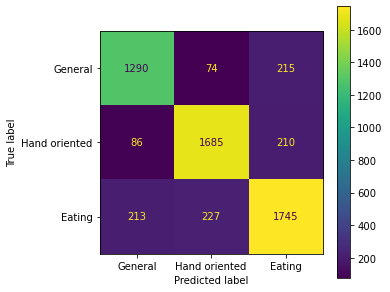

MLPC model for  phone accel


/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy :  54.89206128133704
Validation Accuracy :  48.85987815491732


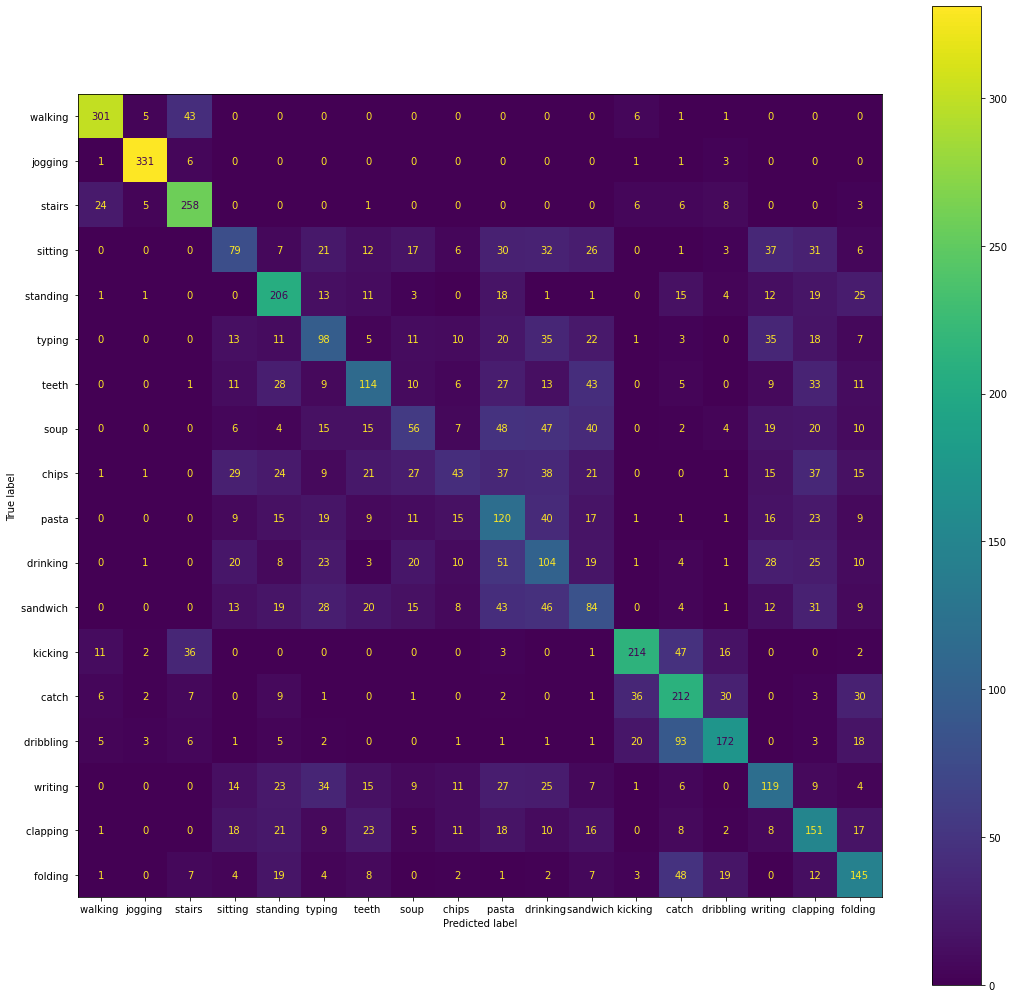

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy :  75.77762302692665
Validation Accuracy :  71.15752828546562


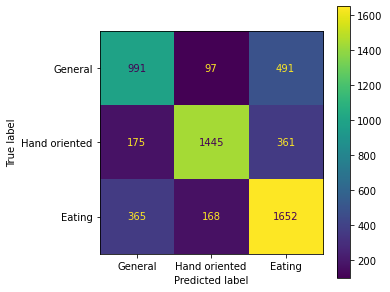

SVC model for  phone accel


/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy :  28.278783658310118
Validation Accuracy :  27.885117493472585


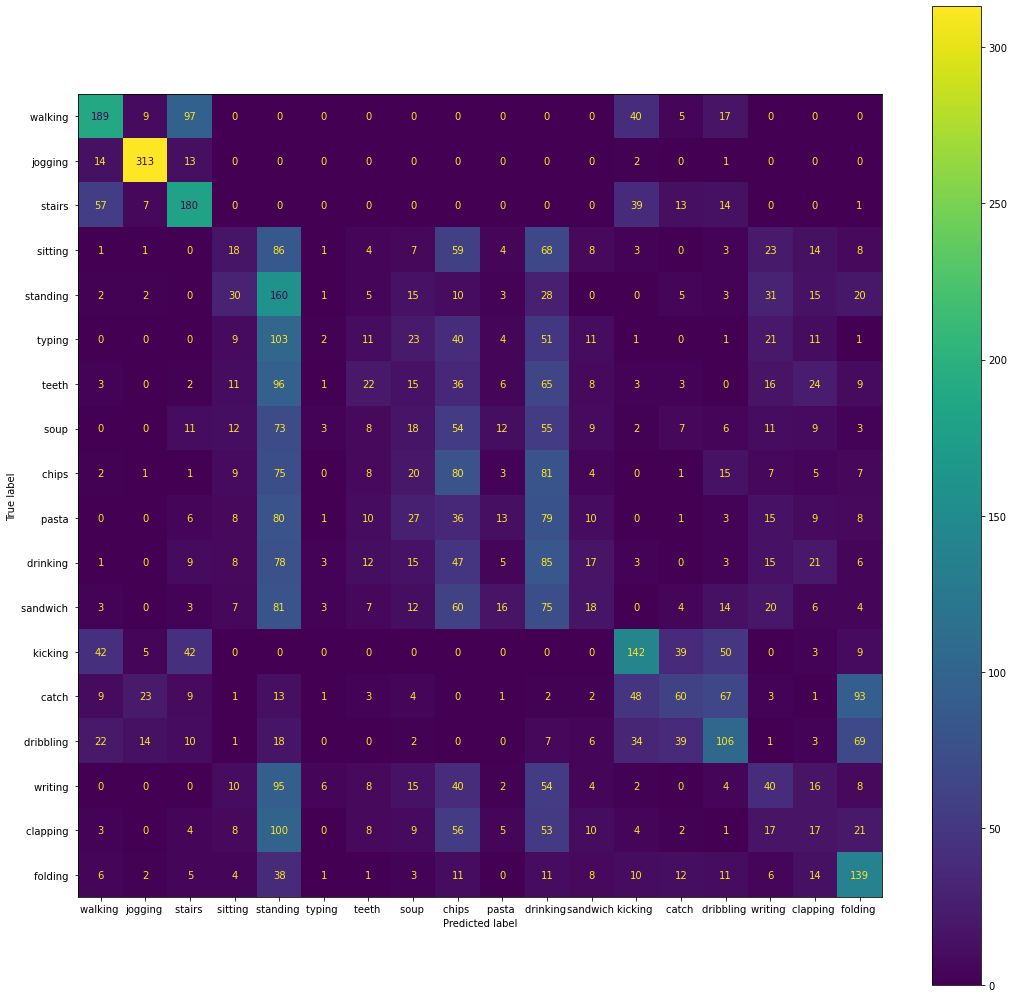

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy :  60.277390900649955
Validation Accuracy :  60.97476066144474


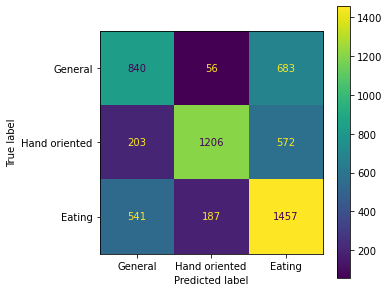

reading data for  phone gyro
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50
kNN model for  phone gyro


/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


kNN model accuracy for phone gyro using activity data 0.17010309278350516


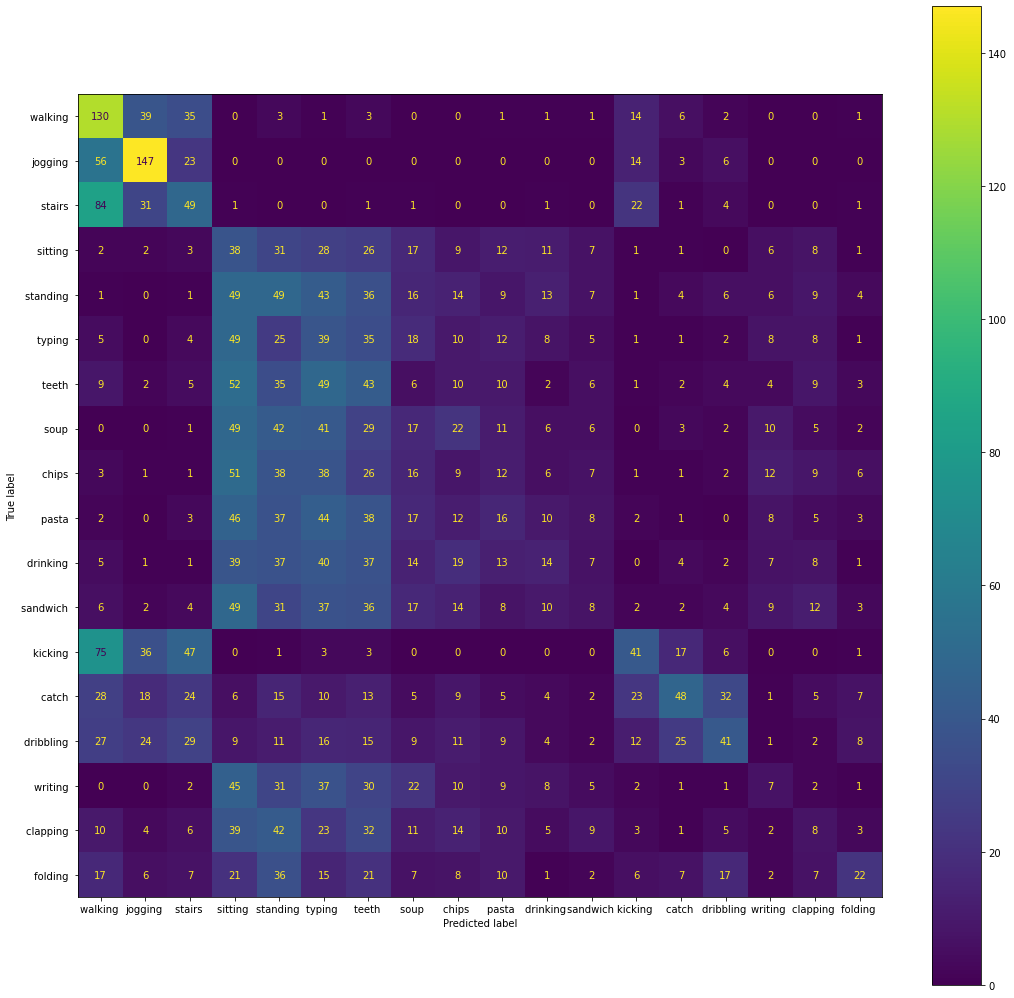

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


kNN model accuracy for phone gyro using simplified activity data 0.5332708528584817


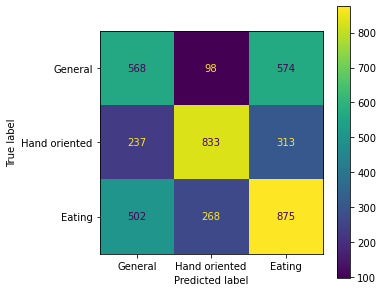

Random forest model for  phone gyro


<ipython-input-16-ec1dfd7c2796>:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  42.78350515463917


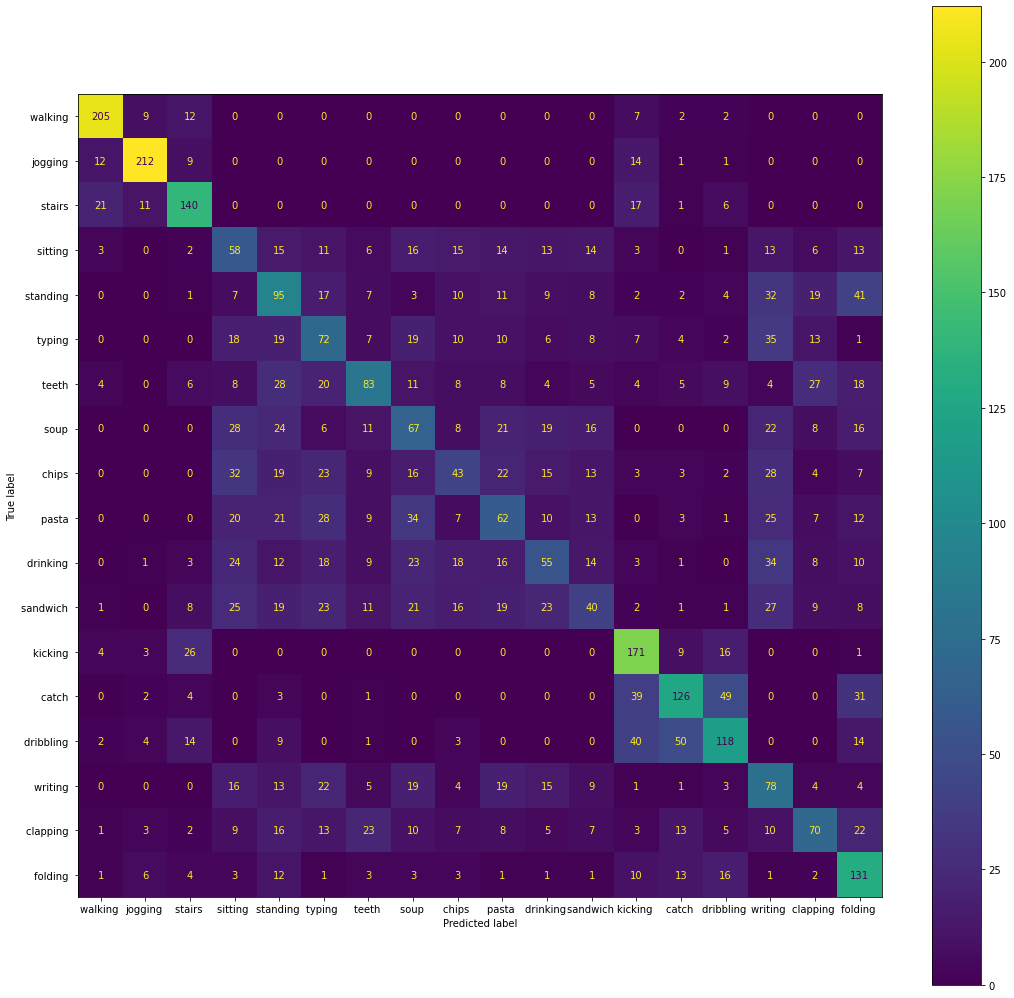

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-16-ec1dfd7c2796>:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  68.90815370196813


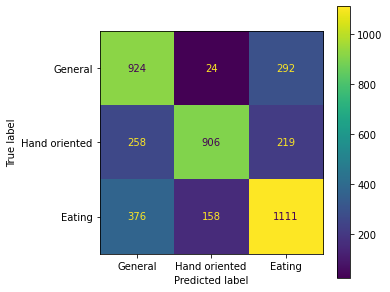

Decision tree model for  phone gyro
Training Accuracy :  100.0
Validation Accuracy :  31.349578256794754


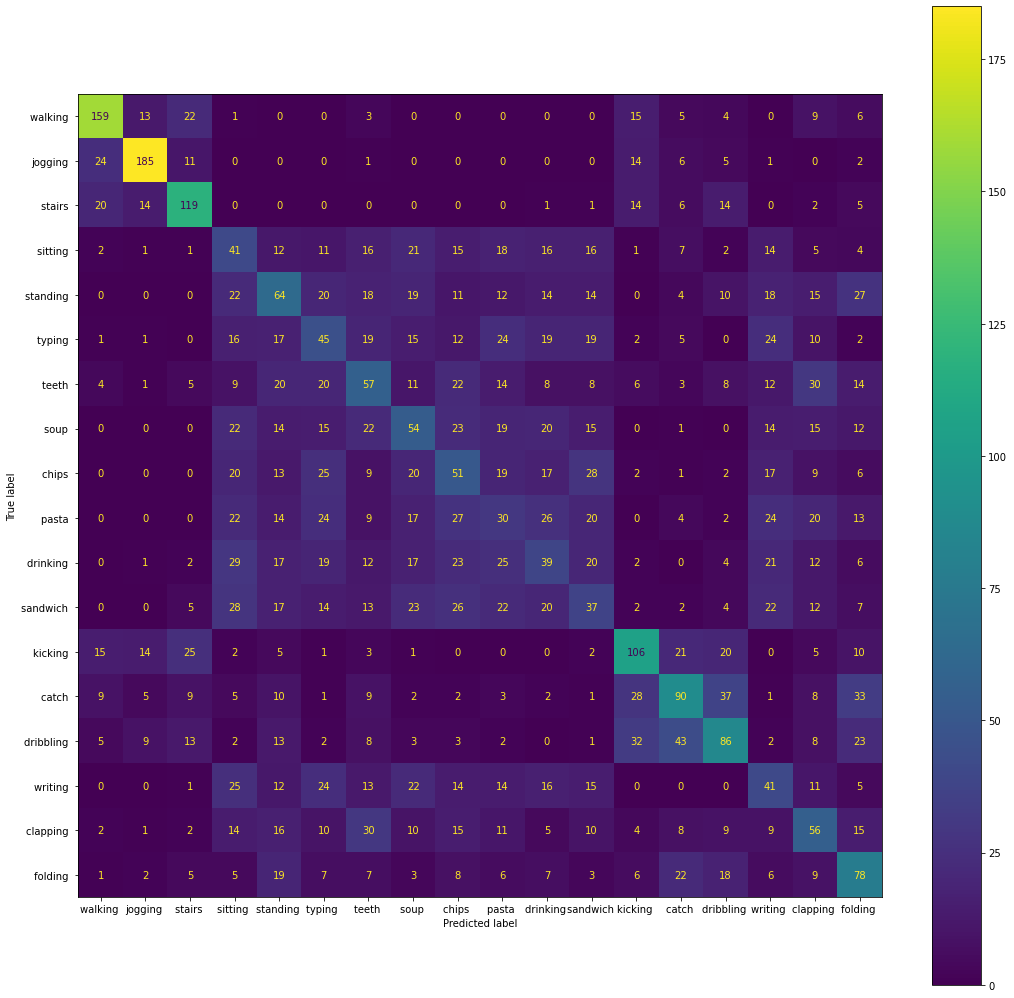

Training Accuracy :  100.0
Validation Accuracy :  56.888472352389876


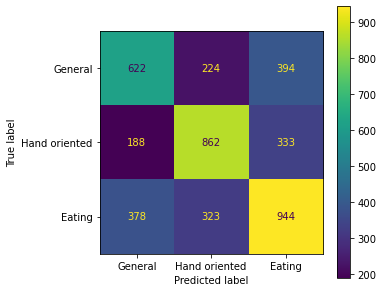

MLPC model for  phone gyro


/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy :  40.642087173879084
Validation Accuracy :  32.61480787253983


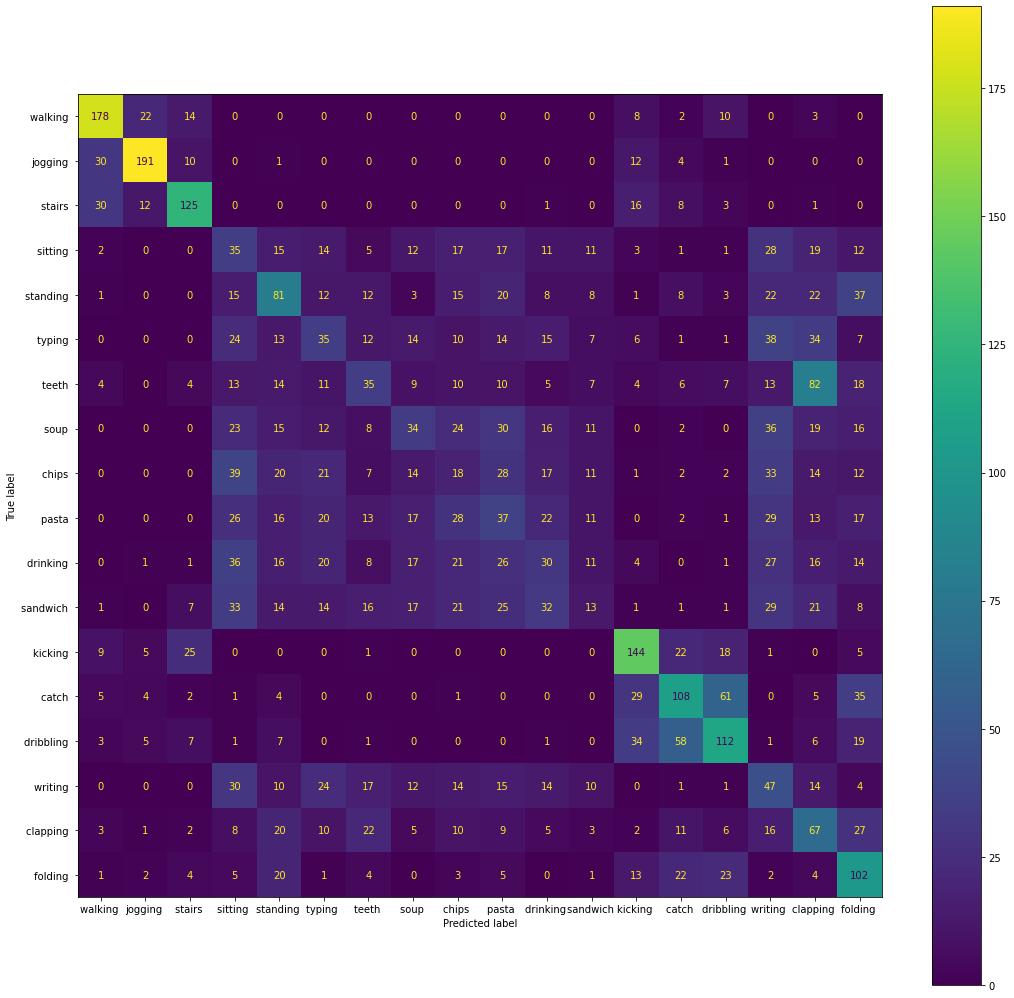

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy :  69.76253710357757
Validation Accuracy :  64.73758200562324


/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


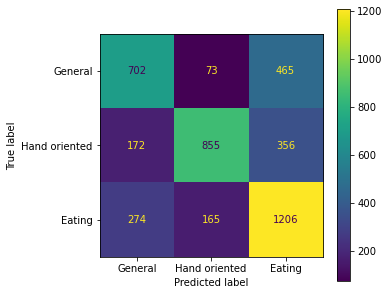

SVC model for  phone gyro


/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy :  21.816903608811124
Validation Accuracy :  19.353327085285848


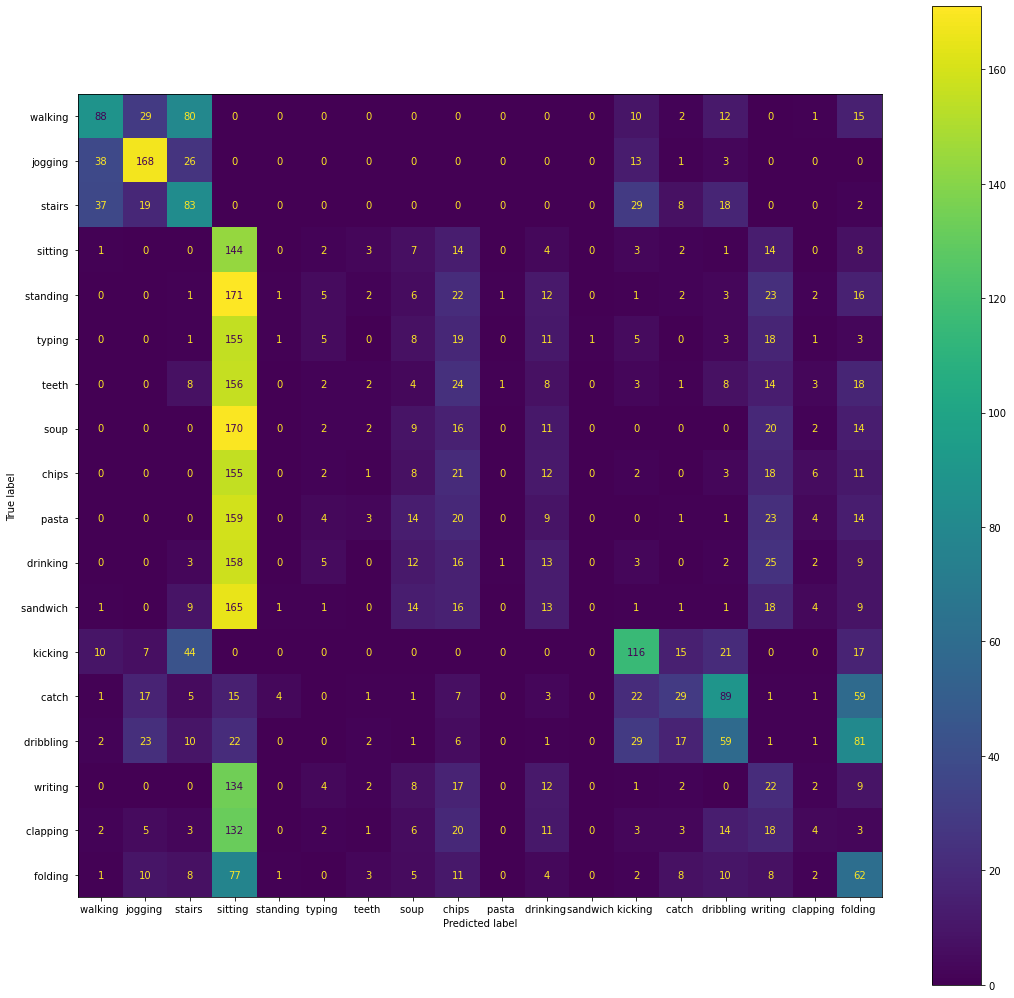

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy :  59.65474144664896
Validation Accuracy :  60.07497656982193


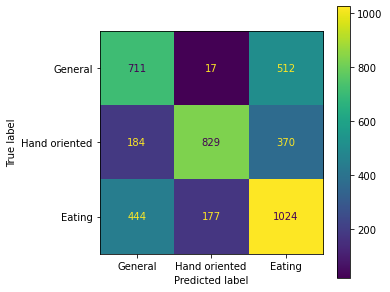

reading data for  watch accel
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50
kNN model for  watch accel


/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


kNN model accuracy for watch accel using activity data 0.6266346992153444


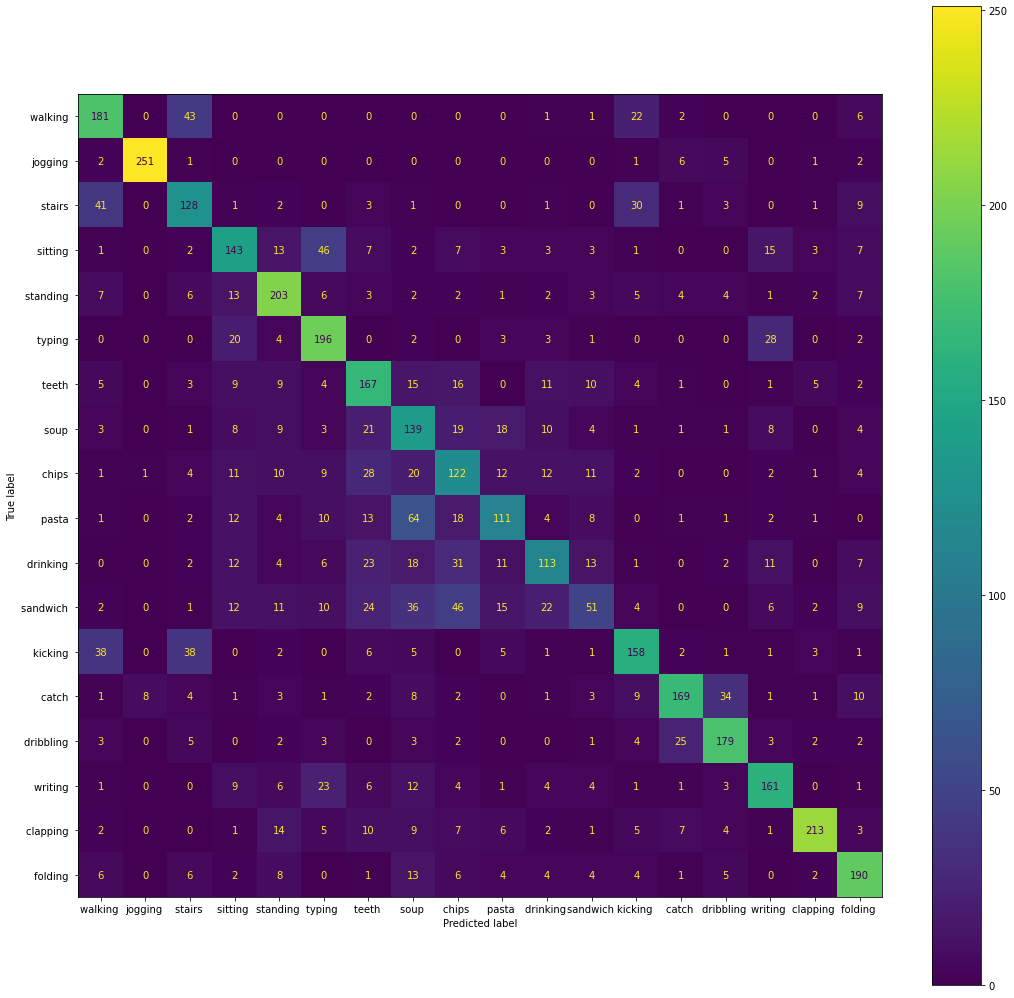

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


kNN model accuracy for watch accel using simplified activity data 0.8299912816041848


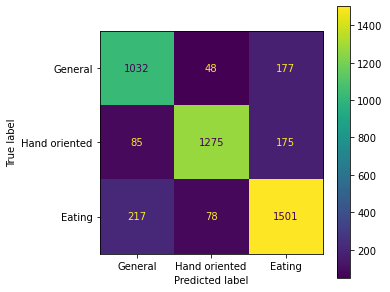

Random forest model for  watch accel


<ipython-input-16-ec1dfd7c2796>:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.79773321708805


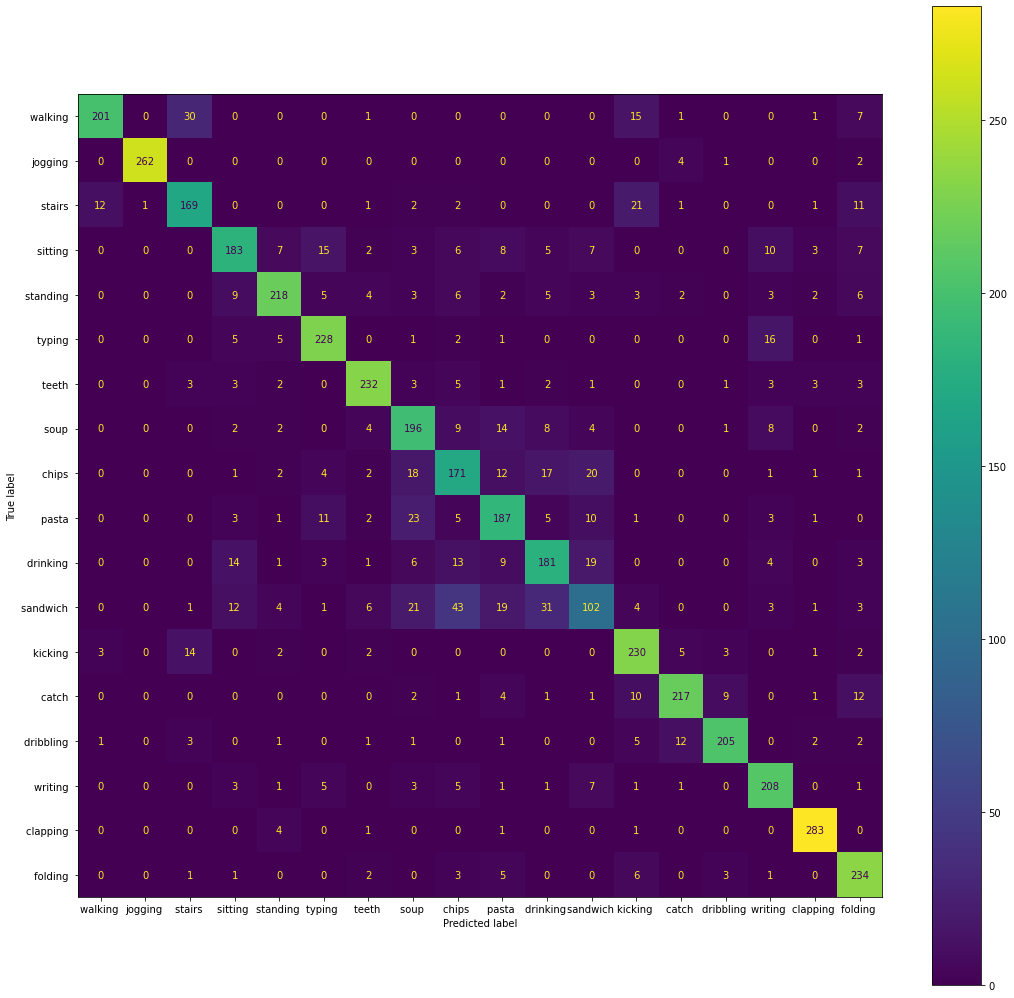

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-16-ec1dfd7c2796>:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  90.9328683522232


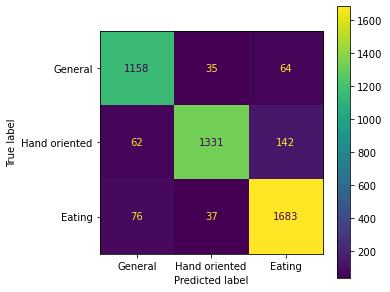

Decision tree model for  watch accel
Training Accuracy :  100.0
Validation Accuracy :  68.52659110723627


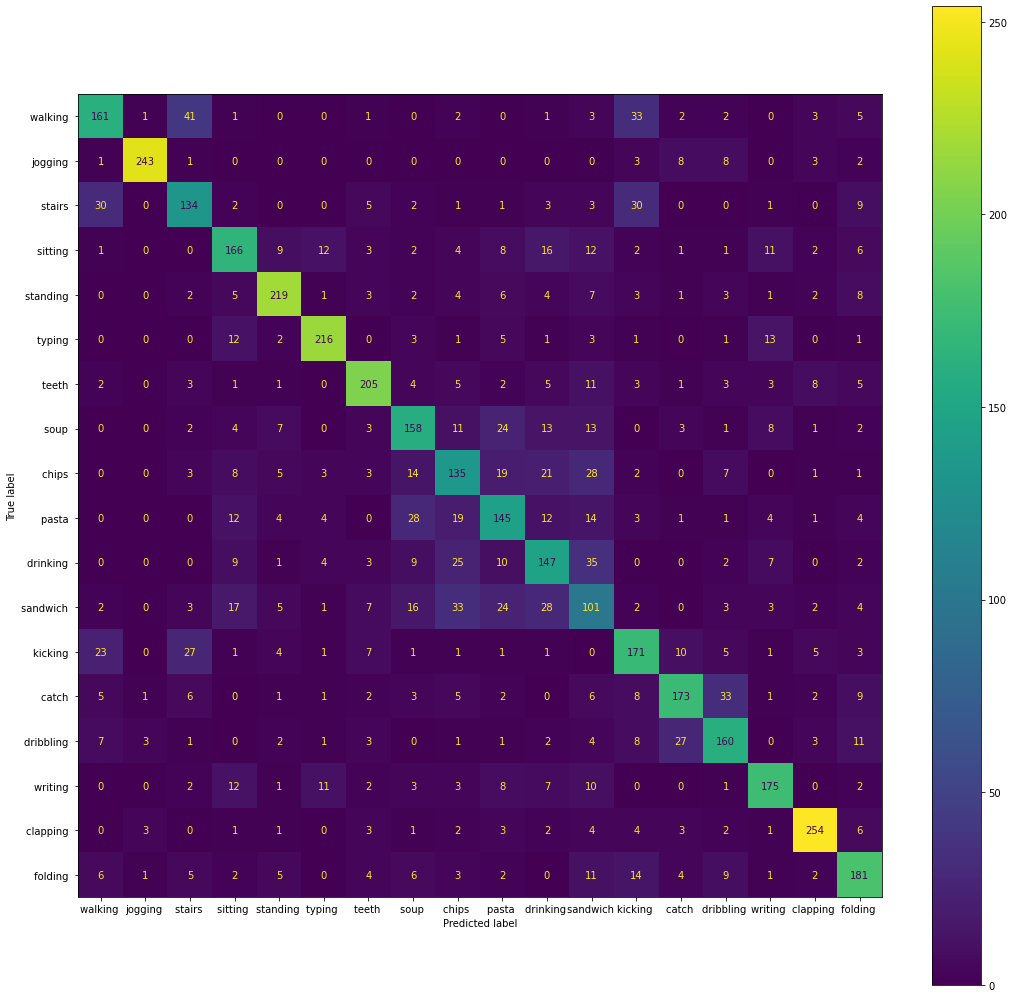

Training Accuracy :  100.0
Validation Accuracy :  85.52746294681779


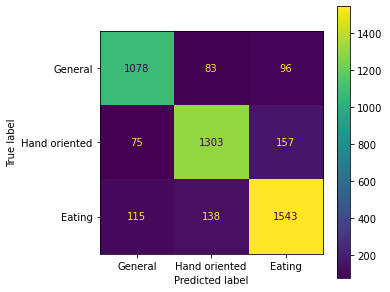

MLPC model for  watch accel


/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy :  79.15425415970356
Validation Accuracy :  71.88317349607672


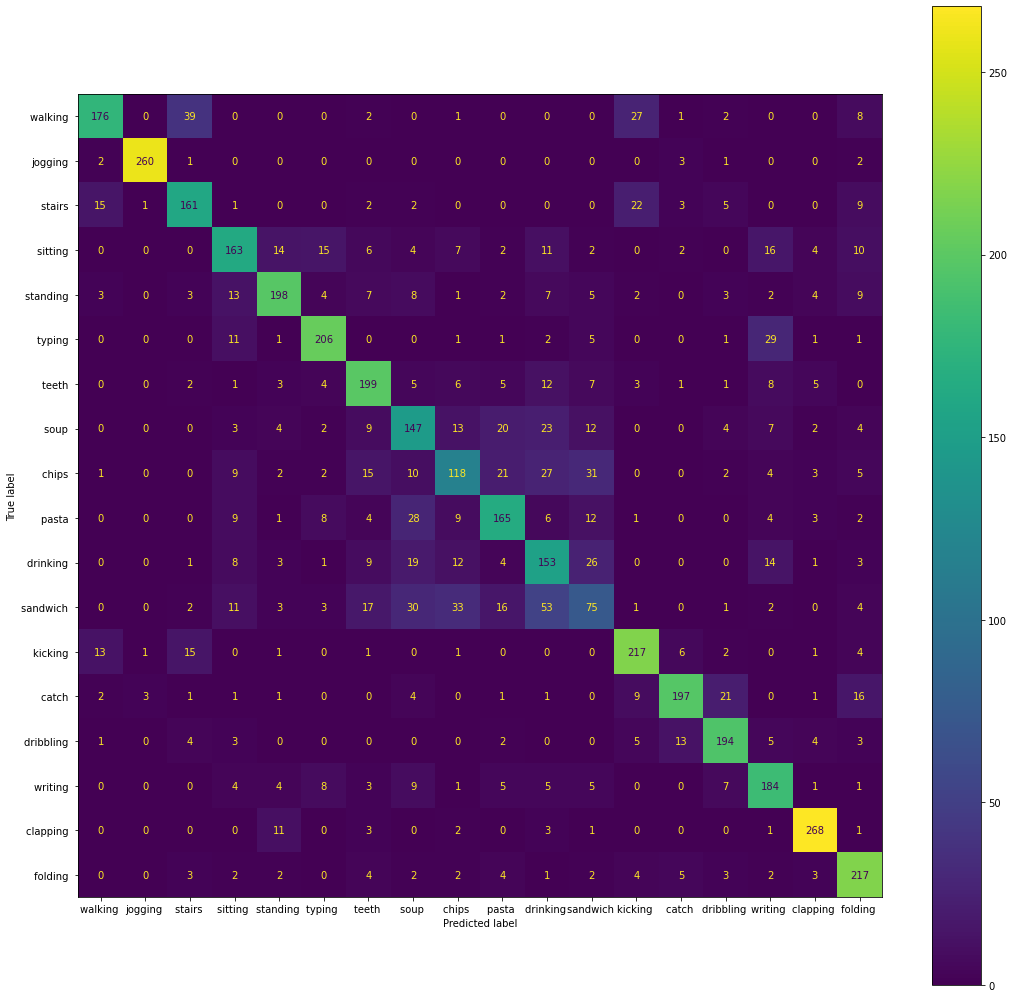

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy :  92.09474678485795
Validation Accuracy :  87.77244986922406


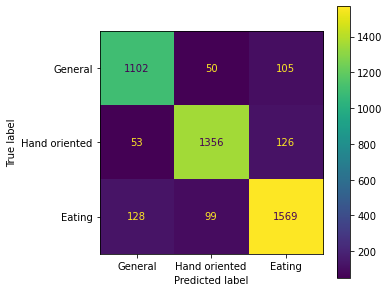

SVC model for  watch accel


/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy :  55.18418949356971
Validation Accuracy :  54.468177855274625


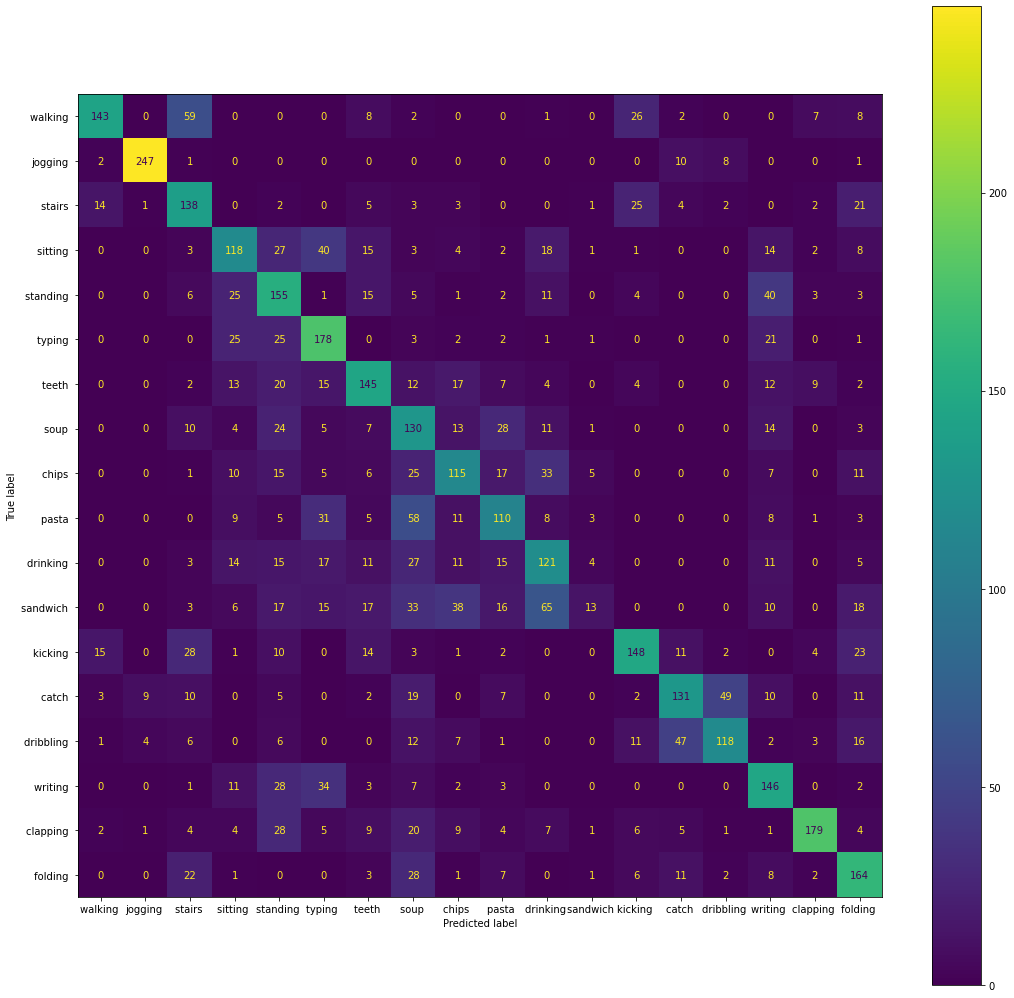

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy :  72.87655307709076
Validation Accuracy :  72.68962510897995


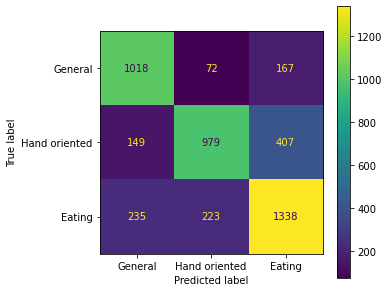

reading data for  watch gyro
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50
kNN model for  watch gyro


/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


kNN model accuracy for watch gyro using activity data 0.3040442946557535


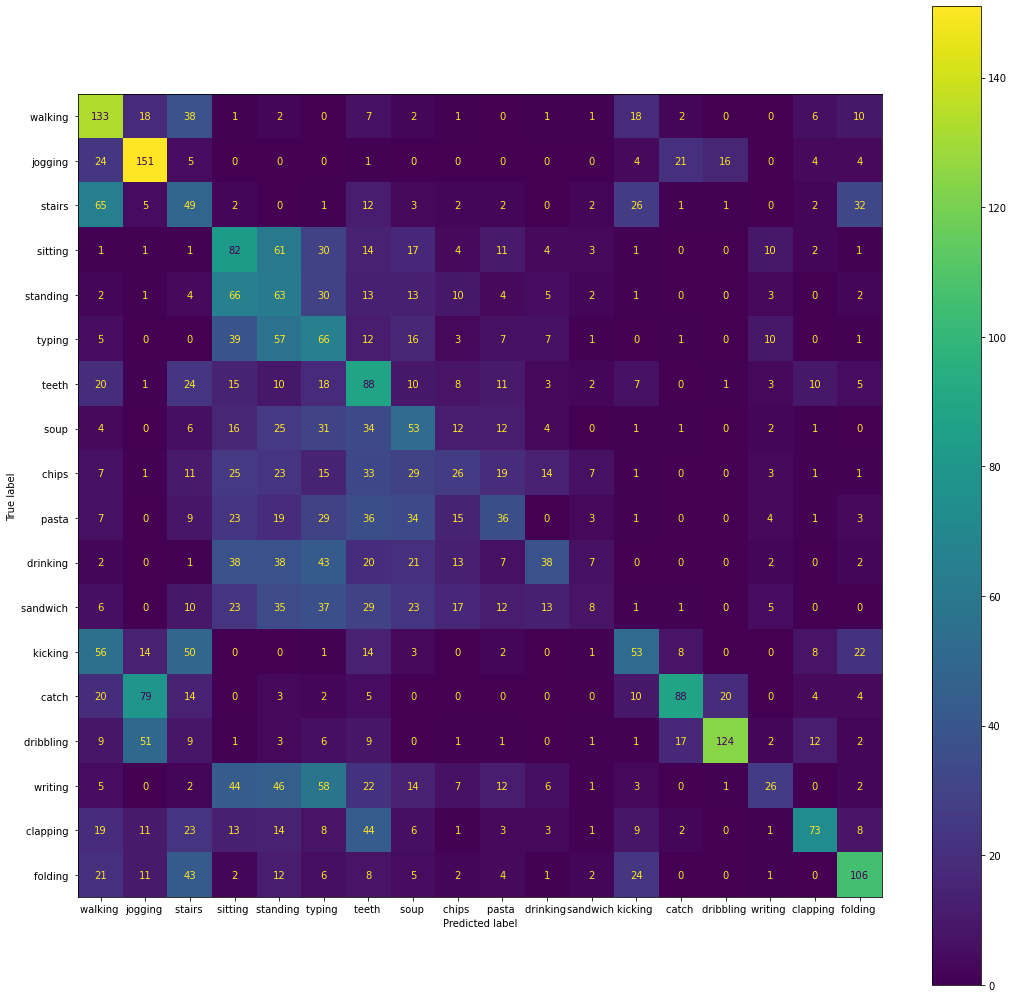

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


kNN model accuracy for watch gyro using simplified activity data 0.6003851709195955


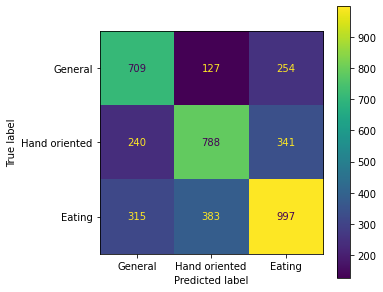

Random forest model for  watch gyro


<ipython-input-16-ec1dfd7c2796>:69: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  63.48098218584497


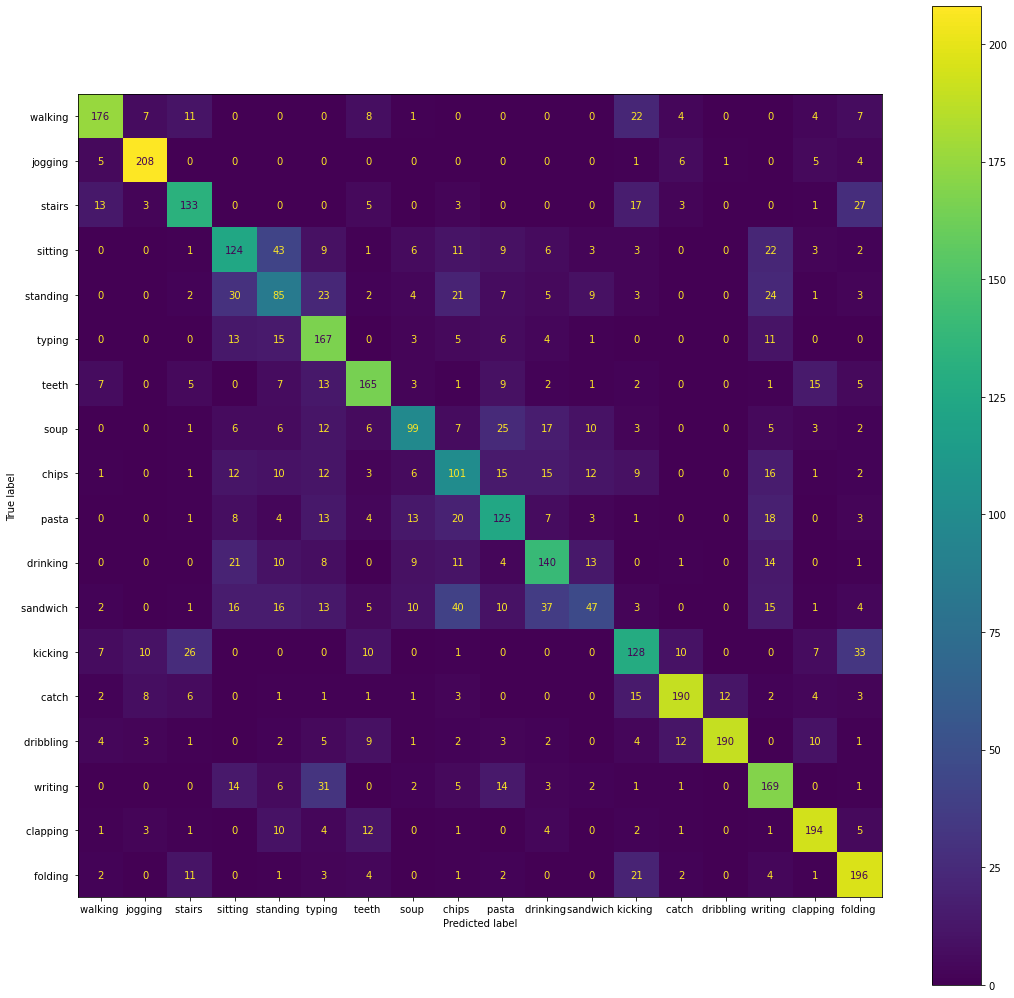

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-16-ec1dfd7c2796>:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.90996629754453


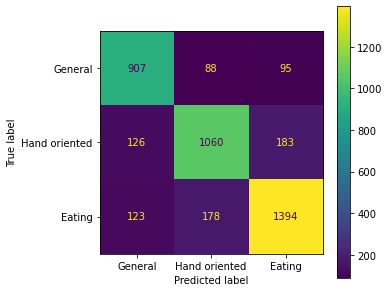

Decision tree model for  watch gyro
Training Accuracy :  100.0
Validation Accuracy :  46.75012036591237


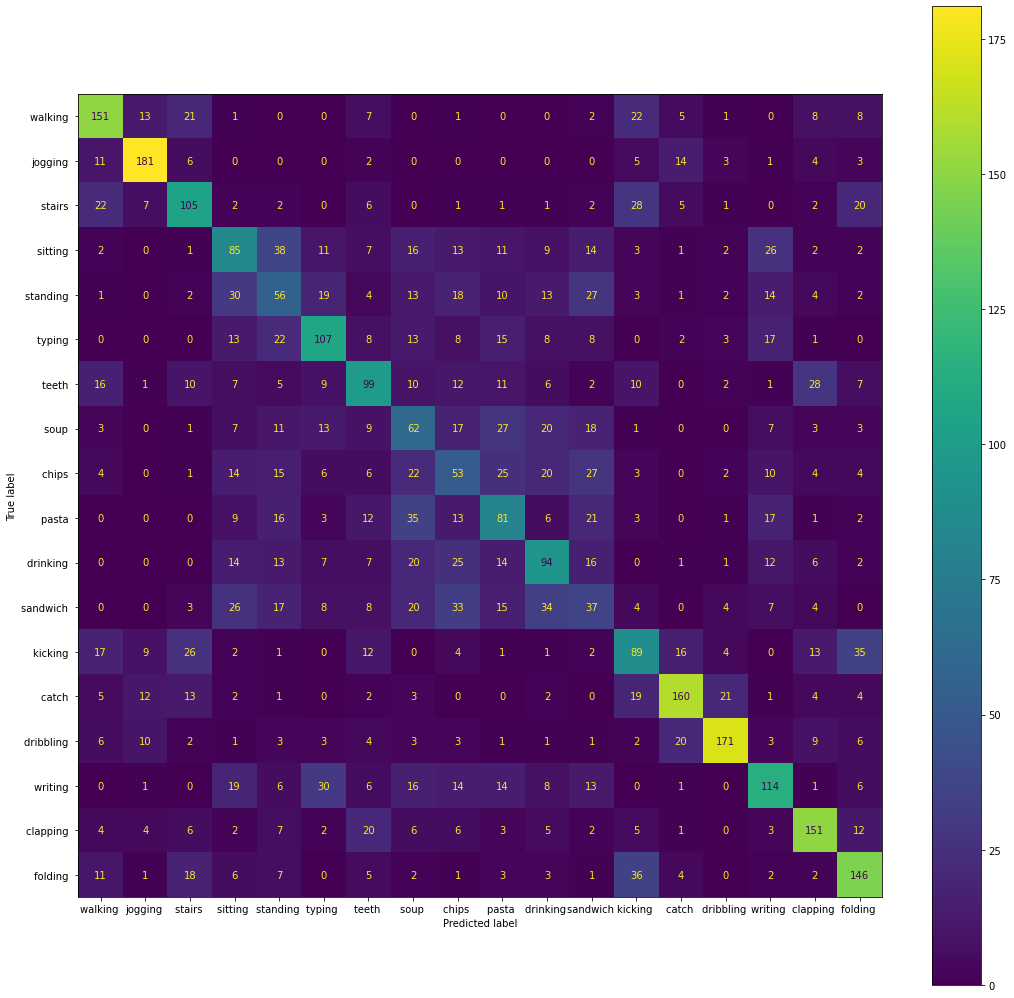

Training Accuracy :  100.0
Validation Accuracy :  68.99374097255657


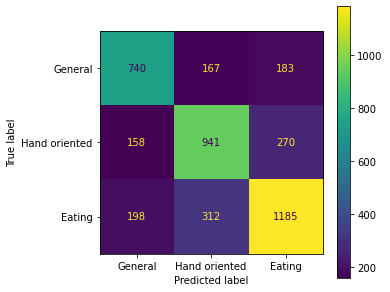

MLPC model for  watch gyro


/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy :  63.14310939882816
Validation Accuracy :  57.366393837265285


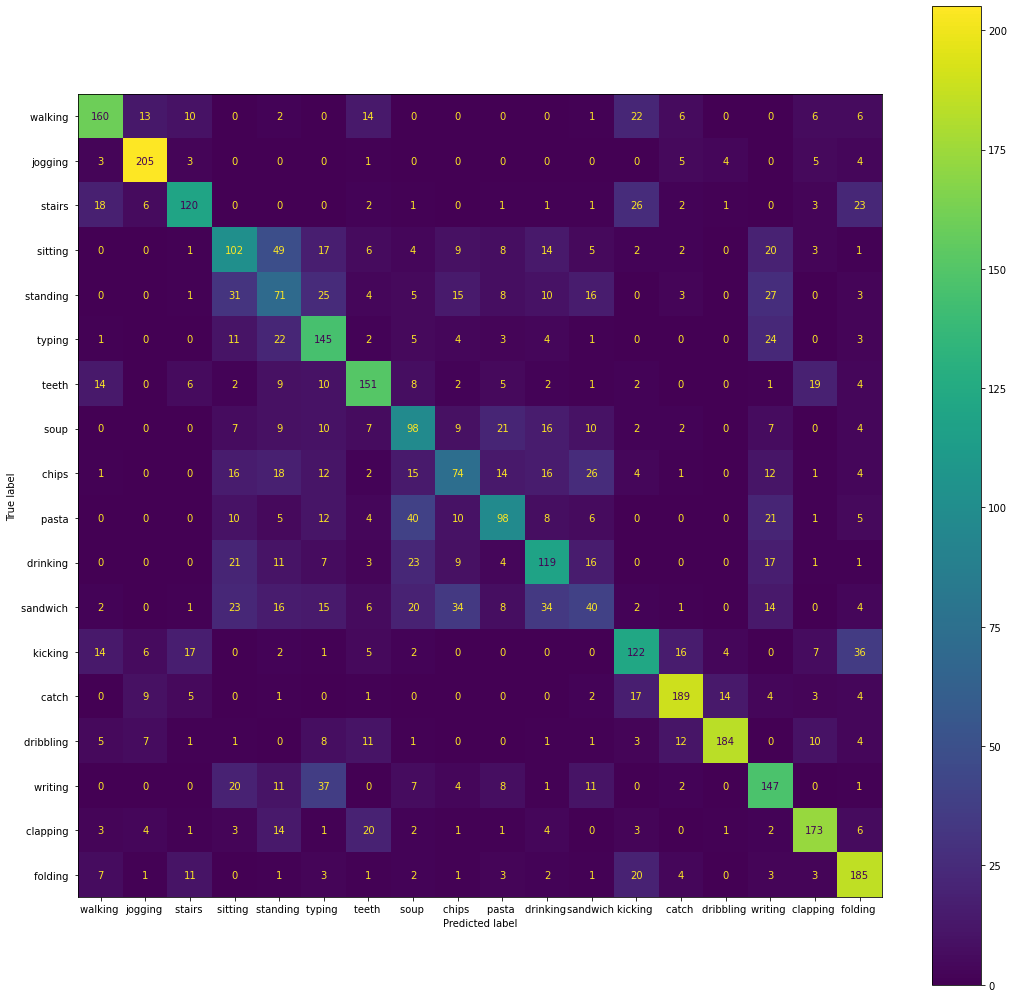

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy :  81.92471305883298
Validation Accuracy :  76.52864708714492


/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


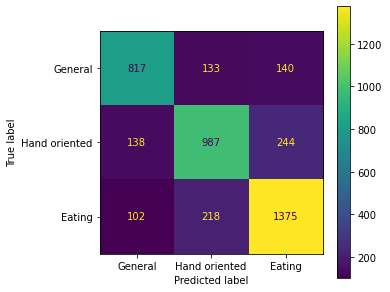

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC model for  watch gyro
Training Accuracy :  43.101372501805926
Validation Accuracy :  43.066923447279734


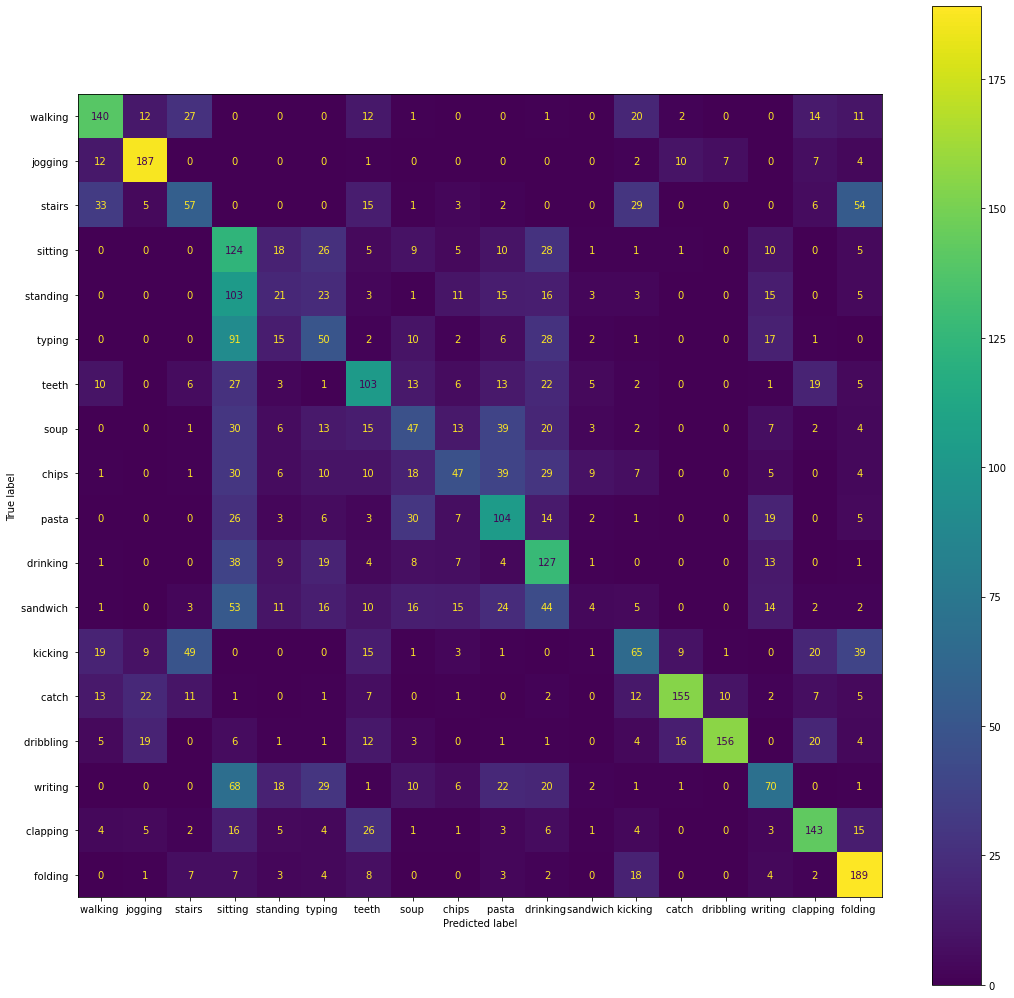

/Users/dav/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy :  61.18468576932338
Validation Accuracy :  61.24217621569571


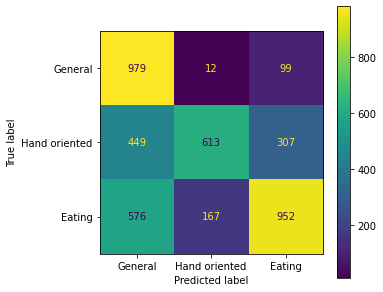

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn import metrics

devices = ["phone","watch"]
measurements = ["accel","gyro"]

for dev in devices:
    for msr in measurements:
        print('reading data for ',dev,msr)
        features, target_A, target_B, target_C = data_reducer(dev,msr,200)
        ################### KNN ###################
        print("kNN model for ",dev,msr)
        X=features
        y=target_A

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

        # training the model on training set
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)

        # making predictions on the testing set
        y_pred = knn.predict(X_test)

        # comparing actual response values (y_test) with predicted response values (y_pred)
        print("kNN model accuracy for",dev,msr,'using activity data', metrics.accuracy_score(y_test, y_pred))

        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = activity)
        fig, ax = plt.subplots(figsize=(18,18))
        cm_display.plot(ax=ax)
        plt.savefig('./confmat_normal_'+dev+'_'+msr+'_kNN.pdf', bbox_inches='tight')
        plt.show()

        X=features
        y=target_C

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

        # training the model on training set
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)

        # making predictions on the testing set
        y_pred = knn.predict(X_test)

        # comparing actual response values (y_test) with predicted response values (y_pred)
        print("kNN model accuracy for",dev,msr,'using simplified activity data', metrics.accuracy_score(y_test, y_pred))
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = activity_broad)
        fig, ax = plt.subplots(figsize=(5,5))
        cm_display.plot(ax=ax)
        plt.savefig('./confmat_reduced_'+dev+'_'+msr+'_kNN.pdf', bbox_inches='tight')
        plt.show()
        ################### random forest ###################
        print("Random forest model for ",dev,msr)
        X=features
        y=target_A

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        print('Training Accuracy : ',
              metrics.accuracy_score(y_train,
                                     model.predict(X_train))*100)
        print('Validation Accuracy : ',
              metrics.accuracy_score(y_test,
                                     model.predict(X_test))*100)
        y_pred = model.predict(X_test)
        
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = activity)
        fig, ax = plt.subplots(figsize=(18,18))
        cm_display.plot(ax=ax)
        plt.savefig('./confmat_normal_'+dev+'_'+msr+'_RF.pdf', bbox_inches='tight')
        plt.show()

        X=features
        y=target_C

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

        # training the model on training set
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)

        # making predictions on the testing set
        y_pred = knn.predict(X_test)
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        print('Training Accuracy : ',
              metrics.accuracy_score(y_train,
                                     model.predict(X_train))*100)
        print('Validation Accuracy : ',
              metrics.accuracy_score(y_test,
                                     model.predict(X_test))*100)
        y_pred = model.predict(X_test)
        
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = activity_broad)
        fig, ax = plt.subplots(figsize=(5,5))
        cm_display.plot(ax=ax)
        plt.savefig('./confmat_reduced_'+dev+'_'+msr+'_RF.pdf', bbox_inches='tight')
        plt.show()
        ################### Decision tree ###################
        print("Decision tree model for ",dev,msr)
        X=features
        y=target_A
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
        clf_entropy = DecisionTreeClassifier()#criterion = "entropy", random_state = 100,max_depth=3, min_samples_leaf=5)
        clf_entropy.fit(X_train, y_train)
        print('Training Accuracy : ',
              metrics.accuracy_score(y_train,
                                     clf_entropy.predict(X_train))*100)
        print('Validation Accuracy : ',
              metrics.accuracy_score(y_test,
                                     clf_entropy.predict(X_test))*100)
        y_pred = clf_entropy.predict(X_test)
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = activity)
        fig, ax = plt.subplots(figsize=(18,18))
        cm_display.plot(ax=ax)
        plt.savefig('./confmat_normal_'+dev+'_'+msr+'_DTM.pdf', bbox_inches='tight')
        plt.show()
        X=features
        y=target_C
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
        clf_entropy = DecisionTreeClassifier()#criterion = "entropy", random_state = 100,max_depth=3, min_samples_leaf=5)
        clf_entropy.fit(X_train, y_train)
        print('Training Accuracy : ',
              metrics.accuracy_score(y_train,
                                     clf_entropy.predict(X_train))*100)
        print('Validation Accuracy : ',
              metrics.accuracy_score(y_test,
                                     clf_entropy.predict(X_test))*100)
        y_pred = clf_entropy.predict(X_test)
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = activity_broad)
        fig, ax = plt.subplots(figsize=(5,5))
        cm_display.plot(ax=ax)
        plt.savefig('./confmat_normal_'+dev+'_'+msr+'_DTM.pdf', bbox_inches='tight')
        plt.show()
        ################### MLPC ###################
        print("MLPC model for ",dev,msr)
        X=features
        y=target_A
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
        mlpc = MLPClassifier()
        y_pred = mlpc.fit(X_train, y_train).predict(X_test)
        print('Training Accuracy : ',
              metrics.accuracy_score(y_train,
                                     mlpc.predict(X_train))*100)
        print('Validation Accuracy : ',
              metrics.accuracy_score(y_test,
                                     mlpc.predict(X_test))*100)
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = activity)
        fig, ax = plt.subplots(figsize=(18,18))
        cm_display.plot(ax=ax)
        plt.savefig('./confmat_normal_'+dev+'_'+msr+'_MLPC.pdf', bbox_inches='tight')
        plt.show()

        X=features
        y=target_C
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
        mlpc = MLPClassifier()
        y_pred = mlpc.fit(X_train, y_train).predict(X_test)
        print('Training Accuracy : ',
              metrics.accuracy_score(y_train,
                                     mlpc.predict(X_train))*100)
        print('Validation Accuracy : ',
              metrics.accuracy_score(y_test,
                                     mlpc.predict(X_test))*100)
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = activity_broad)
        fig, ax = plt.subplots(figsize=(5,5))
        cm_display.plot(ax=ax)
        plt.savefig('./confmat_reduced_'+dev+'_'+msr+'_MLPC.pdf', bbox_inches='tight')
        plt.show()
        ################### SVC ###################        
        print("SVC model for ",dev,msr)

        X=features
        y=target_A
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
        svc = SVC(kernel="linear", C=0.025)
        y_pred = svc.fit(X_train, y_train).predict(X_test)
        print('Training Accuracy : ',
              metrics.accuracy_score(y_train,
                                     svc.predict(X_train))*100)
        print('Validation Accuracy : ',
              metrics.accuracy_score(y_test,
                                     svc.predict(X_test))*100)
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = activity)
        fig, ax = plt.subplots(figsize=(18,18))
        cm_display.plot(ax=ax)
        plt.savefig('./confmat_normal_'+dev+'_'+msr+'_SVC.pdf', bbox_inches='tight')
        plt.show()

        X=features
        y=target_C
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
        svc = SVC(kernel="linear", C=0.025)
        y_pred = svc.fit(X_train, y_train).predict(X_test)
        print('Training Accuracy : ',
              metrics.accuracy_score(y_train,
                                     svc.predict(X_train))*100)
        print('Validation Accuracy : ',
              metrics.accuracy_score(y_test,
                                     svc.predict(X_test))*100)
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = activity_broad)
        fig, ax = plt.subplots(figsize=(5,5))
        cm_display.plot(ax=ax)
        plt.savefig('./confmat_reduced_'+dev+'_'+msr+'_SVC.pdf', bbox_inches='tight')
        plt.show()



50
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  76.15160034602077
76.15160034602077
60
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  76.82119205298014
76.82119205298014
70
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  77.49543517954962
77.49543517954962
80
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  77.92410327499567
77.92410327499567
90
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  78.7078542194504
78.7078542194504
100
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  78.65655471289274
78.65655471289274
110
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  78.90983804689388
78.90983804689388
120
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  79.34400624755955
79.34400624755955
130
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  79.90252293577981
79.90252293577981
140
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  99.99483924240079
Validation Accuracy :  79.33116581514166
79.33116581514166
150
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  79.93480032599837
79.93480032599837
160
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.26431718061674
80.26431718061674
170
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.27752081406105
80.27752081406105
180
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.9757053291536
80.9757053291536
190
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.64447289799402
80.64447289799402
200
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  81.03748910200524
81.03748910200524
210
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.97415961582438
80.97415961582438
220
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  81.43930215653018
81.43930215653018
230
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.88121618139654
80.88121618139654
240
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  81.06199319905834
81.06199319905834
250
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  81.3071171420659
81.3071171420659
260
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.35450516986707
80.35450516986707
270
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.51175245462659
80.51175245462659
280
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.21167415009621
80.21167415009621
290
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.22617124394185
80.22617124394185
300
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.60486522024983
80.60486522024983
310
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  81.14466292134831
81.14466292134831
320
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  81.82461103253182
81.82461103253182
330
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.49618320610688
80.49618320610688
340
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.80030781069642
80.80030781069642
350
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.37999224505621
80.37999224505621
360
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  81.62376237623762
81.62376237623762
370
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.30625265844321
80.30625265844321
380
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  81.81818181818183
81.81818181818183
390
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.7442665512765
80.7442665512765
400
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  79.52548330404218
79.52548330404218
410
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  78.9549376797699
78.9549376797699
420
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  81.94911185789726
81.94911185789726
430
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  79.60271317829456
79.60271317829456
440
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  81.5227934044617
81.5227934044617
450
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.0
80.0
460
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.72945019052804
80.72945019052804
470
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  80.94978165938865
80.94978165938865
480
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  79.90088105726872
79.90088105726872
490
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  79.88980716253444
79.88980716253444
500
1600  out of 50
1610  out of 50
1620  out of 50
1630  out of 50
1640  out of 50
1650  out of 50


<ipython-input-20-5973de9ed7d0>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Training Accuracy :  100.0
Validation Accuracy :  79.49860724233983
79.49860724233983


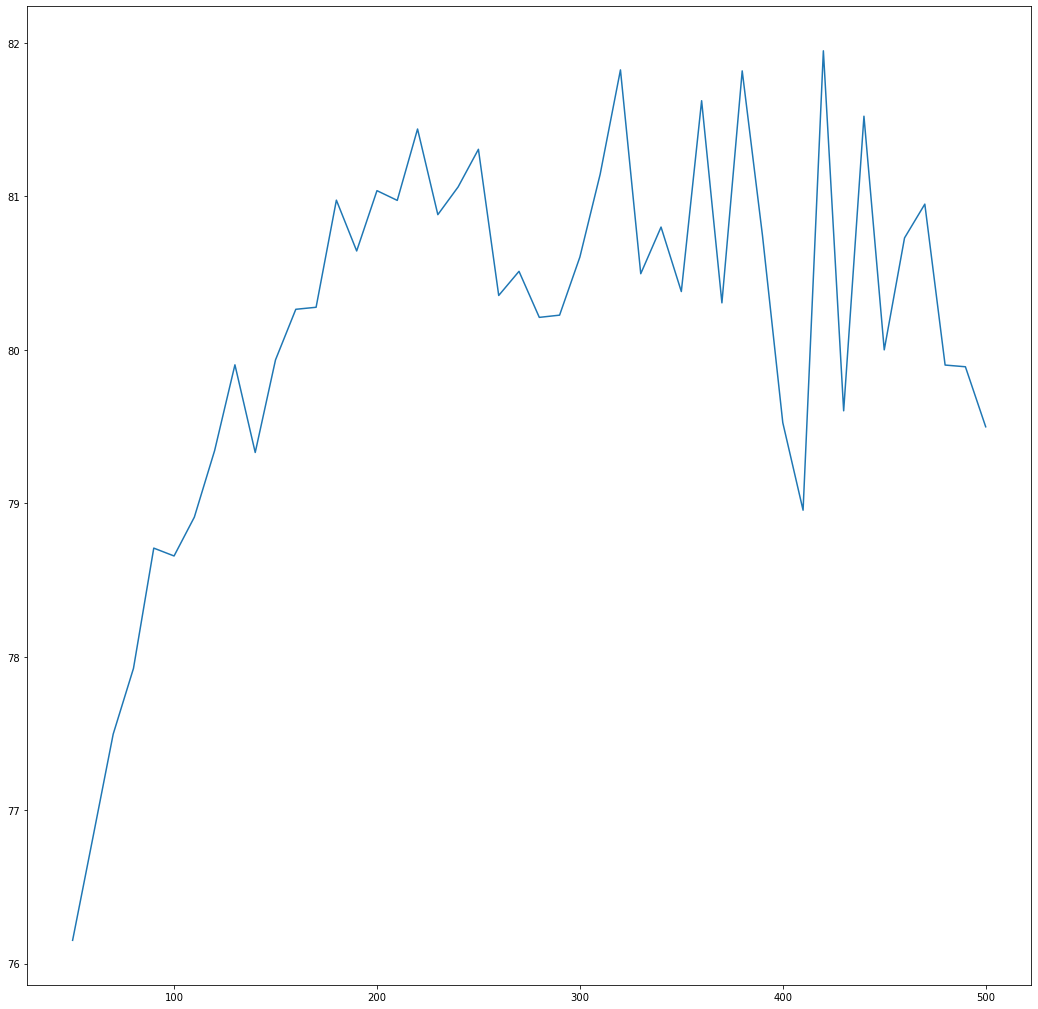

In [20]:
nsteps = []
accuracy = []

for n in range(50,510,10):
    print(n)
    nsteps.append(n)
    features, target_A, target_B, target_C = data_reducer('watch','accel',n)
    X=features
    y=target_A

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    print('Training Accuracy : ',
          metrics.accuracy_score(y_train,
                                 model.predict(X_train))*100)
    print('Validation Accuracy : ',
          metrics.accuracy_score(y_test,
                                 model.predict(X_test))*100)
    y_pred = model.predict(X_test)
    print(metrics.accuracy_score(y_test,model.predict(X_test))*100)
    accuracy.append(metrics.accuracy_score(y_test,model.predict(X_test))*100)
fig, ax = plt.subplots(figsize=(18,18))
ax.plot(nsteps,accuracy)
#plt.savefig('./confmat_normal_'+dev+'_'+msr+'_RF.pdf', bbox_inches='tight')
plt.show()

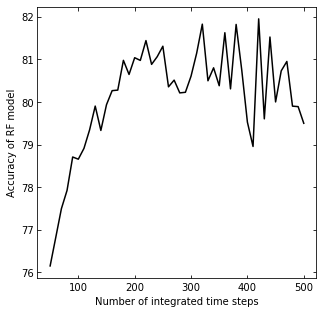

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(nsteps,accuracy, c='black',linestyle='-')
ax.set_xlabel("Number of integrated time steps")
#ax.set_ylim(-20,20)
ax.tick_params(direction="in", which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
fig.set_size_inches([5,5])
ax.set_ylabel(r"Accuracy of RF model")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)

plt.savefig('./time_plot.pdf', bbox_inches='tight')
plt.show()